## Pipeline Strategy

1. Load Dataset
2. Text Preprocessing
   - Lowercasing
   - Remove Punctuation
   - Remove Stop Words
   - Stemming or Lemmatization
3. Text Vectorization
   - BoW / TF-IDF (one per notebook)
4. Train-Test Split
5. Train Model (Logistic Regression or any simple classifier)
6. Evaluate (Accuracy, Confusion Matrix)

# Step 1: Import Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1B. NLP + ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1C. Preprocessing
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Step 2: Load & Combine Data

In [27]:
# 2A. Load Datasets
fake_df = pd.read_csv('../data/Fake.csv')
real_df = pd.read_csv('../data/True.csv')

# 2B. Add Labels
fake_df['label'] = 1  # Fake news
real_df['label'] = 0  # Real news

# 2C. Combine Datasets
df = pd.concat([fake_df, real_df], ignore_index=True)

# 2D. Drop duplicate articles based on 'text' only
print("Duplicates before dropping:", df.duplicated(subset='text').sum())
df = df.drop_duplicates(subset='text')
print("Remaining duplicates after dropping:", df.duplicated(subset='text').sum())

# 2E. Shuffle and keep only necessary columns
df = df.sample(frac=1).reset_index(drop=True)
df = df[['text', 'label']]
df.dropna(inplace=True)

# 2F. Check sample size and label distribution
print(f"\n✅ Total Cleaned Samples: {len(df)}")
print("Class Distribution:\n", df['label'].value_counts())
df.head()

Duplicates before dropping: 6252
Remaining duplicates after dropping: 0

✅ Total Cleaned Samples: 38646
Class Distribution:
 label
0    21191
1    17455
Name: count, dtype: int64


,text,label
0,"God family, guns and country these are some of...",1
1,It s really interesting to hear this panel go...,1
2,One man s stand for freedom ended disastrous...,1
3,SARTRE 21st Century WireThe only conclusion an...,1
4,ANKARA (Reuters) - A strong earthquake of magn...,0


# Step 3: Text Preprocessing Function

In [28]:
# 3A. Define Preprocessing Function

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words with numbers

    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens) #Converts the cleaned word list back into a string for modeling.

# 3B. Apply Preprocessing

df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text', 'label']].head()
    

,text,clean_text,label
0,"God family, guns and country these are some of...",god famili gun countri import thing major repu...,1
1,It s really interesting to hear this panel go...,realli interest hear panel go ballist nikki ha...,1
2,One man s stand for freedom ended disastrous...,one man stand freedom end disastr forgot look ...,1
3,SARTRE 21st Century WireThe only conclusion an...,sartr centuri wireth conclus honest american c...,1
4,ANKARA (Reuters) - A strong earthquake of magn...,ankara reuter strong earthquak magnitud struck...,0


# Step 4: Vectorization (BoW)

In [29]:
# 4A. BoW Vectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

# Step 5: Train-Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size= 0.2, random_state = 46)

# Step 6: Model Training (Logistic Regression)

In [36]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

# Step 7: Evaluation

In [38]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9946959896507115

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4263
           1       1.00      0.99      0.99      3467

    accuracy                           0.99      7730
   macro avg       0.99      0.99      0.99      7730
weighted avg       0.99      0.99      0.99      7730


Confusion Matrix:
 [[4251   12]
 [  29 3438]]


# Visualization for BoW: CountVectorizer

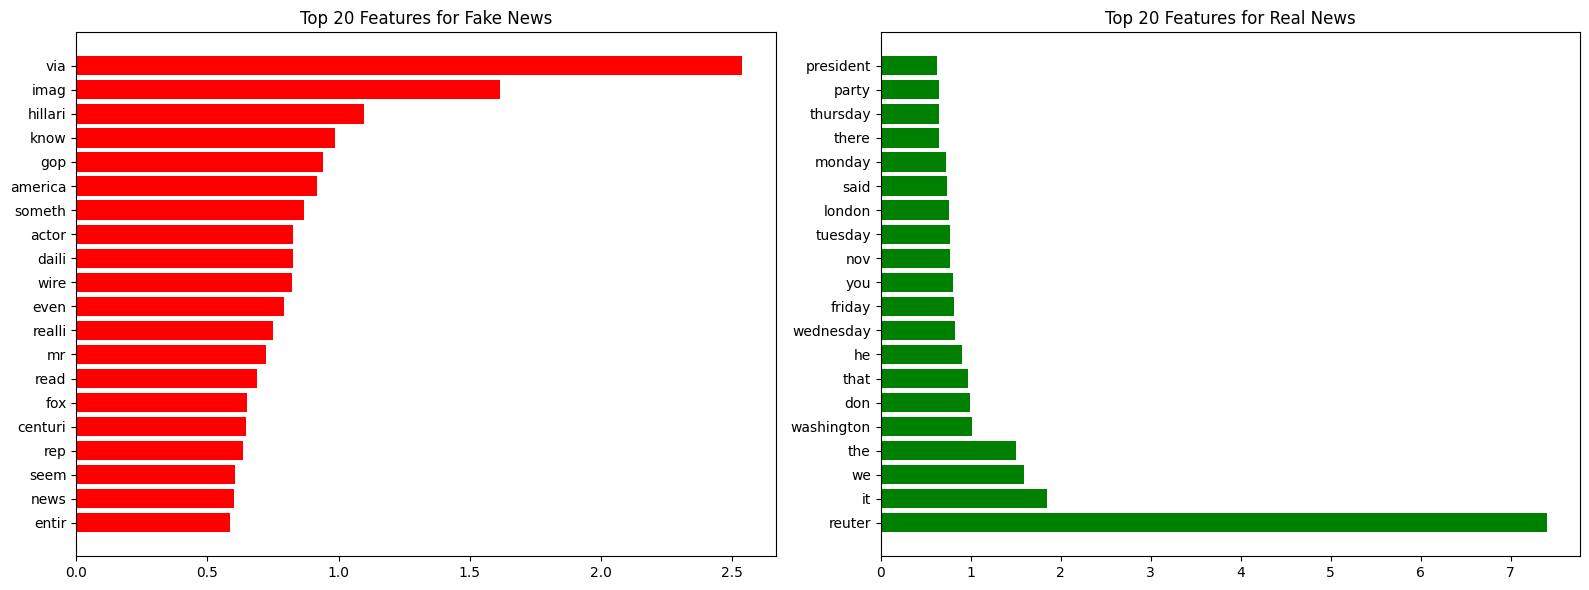

In [39]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get model coefficients
coefficients = model.coef_[0]

# Top 20 features for Fake News
top_fake_idx = np.argsort(coefficients)[-20:]
top_fake_features = [feature_names[i] for i in top_fake_idx]
top_fake_weights = coefficients[top_fake_idx]

# Top 20 features for Real News
top_real_idx = np.argsort(coefficients)[:20]
top_real_features = [feature_names[i] for i in top_real_idx]
top_real_weights = coefficients[top_real_idx]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].barh(top_fake_features, top_fake_weights, color='red')
ax[0].set_title("Top 20 Features for Fake News")

ax[1].barh(top_real_features, -top_real_weights, color='green')
ax[1].set_title("Top 20 Features for Real News")

plt.tight_layout()
plt.show()